# **Flooding in Italy - working code**

In [6]:
import sys; sys.path.append('/home/clair/wwa')
from wwa import *

# define smaller region for selection of data
xn = 9; xx = 14; yn = 42; yx = 46

---
## **Data pre-processing**

Datasets used:
- MSWEP: https://www.gloh2o.org/mswep/
- CHIRPS: https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/netcdf/p05/
- CPC: https://psl.noaa.gov/data/gridded/data.cpc.globalprecip.html
- ERA5: processed by Mariam

### **MSWEP**



In [ ]:
# too much data to read & save in one go - save each year individually
for y in range(1979, 2021):
    
    new_fnm = "data/mswep_daily_"+"-".join([str(p) for p in [xn,xx,yn,yx]])+"_"+str(y)+".nc"
    if len(glob.glob(new_fnm)) > 0: continue

    ds = xr.open_mfdataset("/home/clair/Data/mswep_past/"+str(y)+"*.nc").sel(lon = slice(xn,xx), lat = slice(yx,yn)).rename(precipitation = "precip")
    ds.sortby(ds.lat).to_netcdf("data/mswep_daily_"+"-".join([str(p) for p in [xn,xx,yn,yx]])+"_"+str(y)+".nc")

In [7]:
for y in range(2023, 2024):
    
    new_fnm = "data/mswep_daily_"+"-".join([str(p) for p in [xn,xx,yn,yx]])+"_"+str(y)+".nc"
    if len(glob.glob(new_fnm)) > 0: continue
    
    ds = xr.open_mfdataset("/home/clair/Data/mswep_nrt/"+str(y)+"*.nc").sel(lon = slice(xn,xx), lat = slice(yx,yn)).rename(precipitation = "precip")
    ds.sortby(ds.lat).to_netcdf(new_fnm)

### **CPC**

In [2]:
cpc = xr.open_mfdataset("/home/clair/Data/cpc/precip.*.nc").sel(lon = slice(xn,xx), lat = slice(yn,yx))
cpc.sortby(cpc.lat).to_netcdf("data/cpc_daily_"+"-".join([str(p) for p in [xn,xx,yn,yx]])+".nc")

### **CHIRPS**

In [ ]:
chirps = xr.open_mfdataset("/home/clair/Data/chirps_05/*.nc").rename(latitude = "lat", longitude = "lon").sel(lon = slice(xn,xx), lat = slice(yn,yx))
chirps.sortby(chirps.lat).to_netcdf("data/chirps_daily_"+"-".join([str(p) for p in [xn,xx,yn,yx]])+".nc")

### **E-Obs**

In [3]:
eobs = xr.open_mfdataset("/home/clair/Data/e-obs_025/rr_ens_mean_0.25deg_reg_*_v26.0e.nc").rr.rename("precip", latitude = "lat", longitude = "lon").sel(lon = slice(xn,xx), lat = slice(yn,yx))
eobs.to_netcdf("data/eobs_daily_"+"-".join([str(p) for p in [xn,xx,yn,yx]])+".nc")

---
## **Local geography**
- places mentioned in trigger: Emilia-Romagna province; Bologna, Ravenna, Forli-Cesena
- Lamone river rose by over 10 metres within 24h
- also mentioned in news reports: Senio river; Ponticelli  
&nbsp;
- administrative shapefile data downloaded from http://www.diva-gis.org/gdata
- elevation data from http://research.jisao.washington.edu/data_sets/elevation/
- river & river basin shapefiles from https://www.hydrosheds.org/products/hydrobasins

In [ ]:
# load gridded elevation data
elev = xr.open_dataset("../90_data/tbase_elev-0.25deg.nc").elev.sel(lon = slice(5,20), lat = slice(35,50))

# load administrative shapefiles
sf = gpd.read_file("sf/italy-adm1").set_index("NAME_1").loc[["Emilia-Romagna", "Marche"]]

# get lat & lon of places mentioned in trigger
px = {k : get_latlon(k).values() for k in ["Bologna", "Ravenna", "Forli-Cesena", "Lamone River", "Ponticelli", "Bagnacavallo"]}

# load shapefile for river basin & clip to required extent
hb04 = gpd.read_file("sf/hybas-04").clip([xn,yn,xx,yx])

# load shapefile for rivers & clip to Emilia-Romagna region
riv = gpd.read_file("sf/hydroRIVERS/").clip(sf)

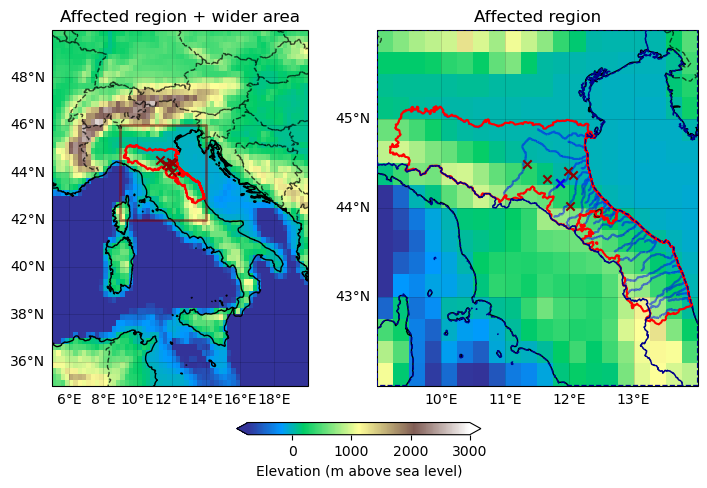

In [13]:
fig, axs = plt.subplots(ncols = 2, figsize = (9,6), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
plt.subplots_adjust(wspace = 0.05)

elev_kwargs = {"cmap" : "terrain", "vmin" : -750, "vmax" : 3000, "add_colorbar" : False}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ax = axs[0] 
cbar = elev.plot(ax = ax, **elev_kwargs)
ax.set_title("Affected region + wider area")

ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.2)

# box for smaller area
ax.plot([xn,xn,xx,xx,xn], [yn,yx,yx,yn,yn], color = "darkred", lw = 2, alpha = 0.5)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ax = axs[1] 
elev.sel(lon = slice(xn,xx), lat = slice(yn,yx)).plot(ax = ax, **elev_kwargs)
ax.set_title("Affected region")
hb04.boundary.plot(ax = ax, color = "darkblue", lw = 1, ls = "--", zorder = 99)

ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.2, xlocs = range(xn, xx+1), ylocs = range(yn, yx+1))

riv.set_index("ORD_CLAS").loc[[1]].plot(ax = ax, color = "blue", alpha = 0.5)
[ax.scatter(*xy, marker = "x", color = "blue", zorder = 999) for k, xy in px.items() if k == "Lamone River"]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

for ax in axs:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)
    
    sf.boundary.plot(ax = ax, color = "red")
    [ax.scatter(*xy, marker = "x", color = "darkred", zorder = 99) for xy in px.values()]

plt.colorbar(cbar, ax = axs, location = "bottom", extend = "both", shrink = 0.35, pad = 0.08, label = "Elevation (m above sea level)")

plt.savefig("fig/physical-geography.png")

---
## **Gridded datasets**

### **Maps of daily precip**

In [90]:
mswep_clim = xr.open_mfdataset("data/mswep_daily_9-14-42-46_19*.nc").precip.groupby("time.month")[5].mean("time").load()
mswep_2023 = xr.open_mfdataset("data/mswep_daily_9-14-42-46_2023.nc").precip.groupby("time.month")[5].load()
mswep_anom = ((mswep_2023 - mswep_clim) / mswep_clim * 100)

sf = gpd.read_file("sf/italy-adm1").set_index("NAME_1").loc[["Emilia-Romagna", "Marche"]]

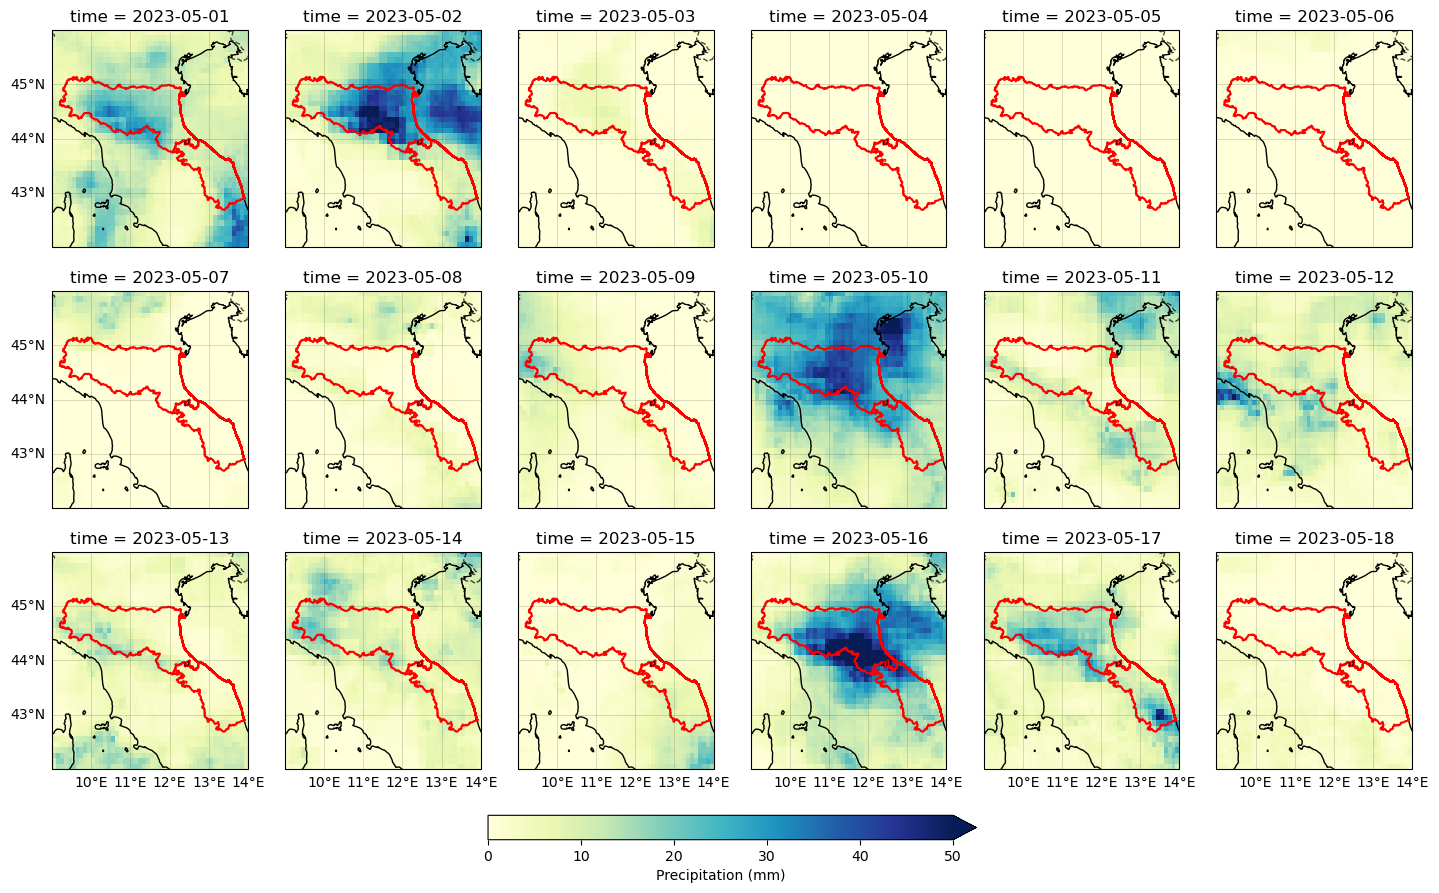

In [94]:
fig, axs = plt.subplots(ncols = 6, nrows = 3, figsize = (18,12), subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, sharex = True, sharey = True)
plt.subplots_adjust(hspace = 0.2, wspace = 0.01)

for i in range(18):
    ax = fig.axes[i]
    cbar = mswep_2023.isel(time = i).plot(ax = ax, cmap = "YlGnBu", vmin = 0, vmax = 50, add_colorbar = False)
    
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)
    sf.boundary.plot(ax = ax, color = "red")
    ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', alpha=0.2, xlocs = range(xn, xx+1), ylocs = range(yn, yx+1))
    
for ax in axs[-1,:]:
    ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels = ["bottom"], alpha=0, xlocs = range(xn+1, xx+1), ylocs = range(yn, yx+1))
for ax in axs[:,0]:
    ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels = ["left"], alpha=0, xlocs = range(xn, xx+1), ylocs = range(yn, yx+1))
    
plt.colorbar(cbar, ax = axs, location = "bottom", extend = "max", shrink = 0.35, pad = 0.05, label = "Precipitation (mm)")

plt.savefig("fig/mswep-precip_2023-05.png")

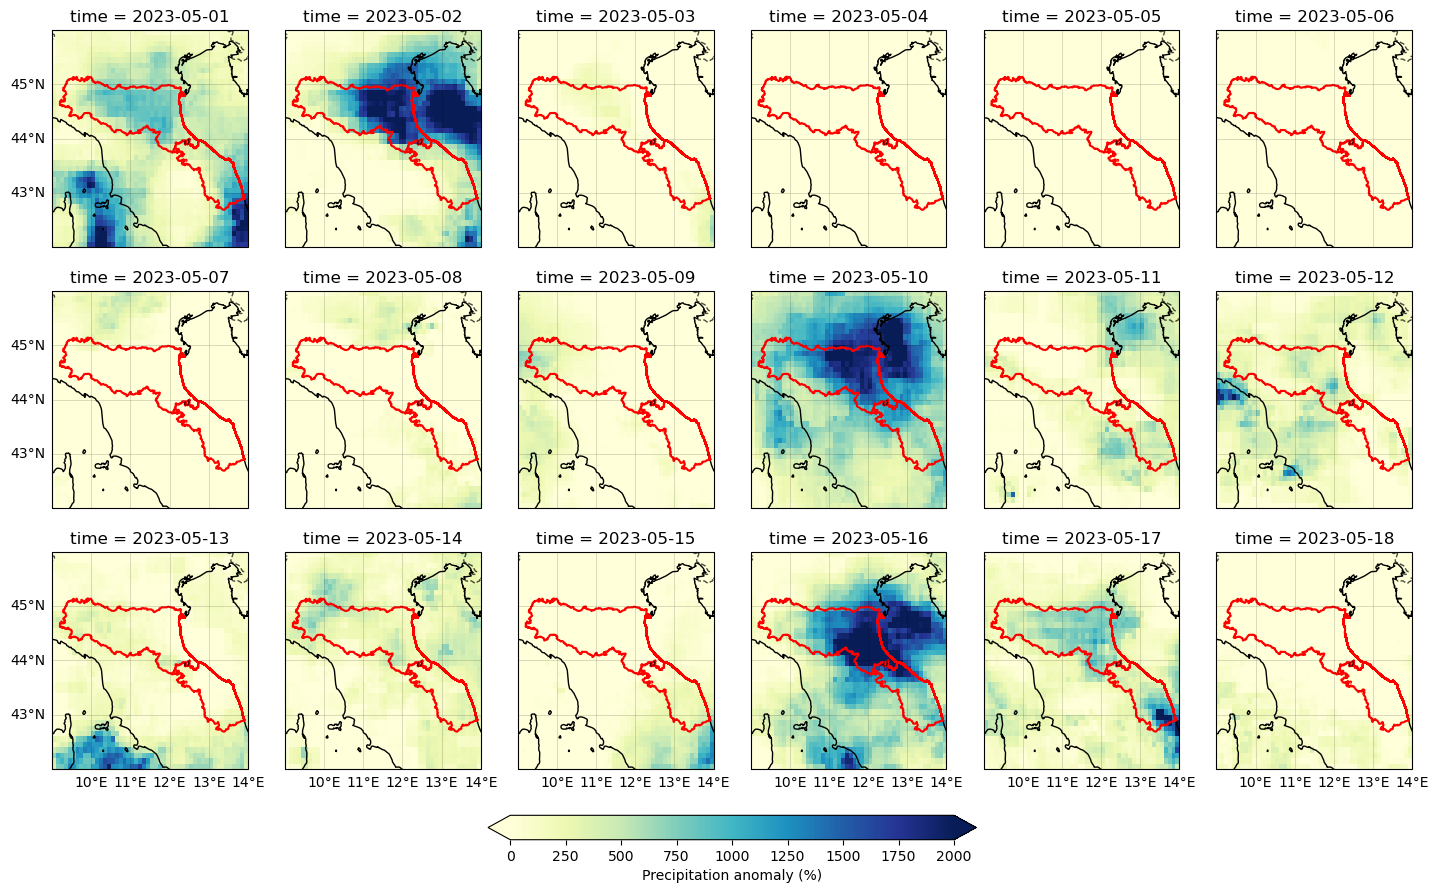

In [96]:
fig, axs = plt.subplots(ncols = 6, nrows = 3, figsize = (18,12), subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, sharex = True, sharey = True)
plt.subplots_adjust(hspace = 0.2, wspace = 0.01)

for i in range(18):
    ax = fig.axes[i]
    cbar = mswep_anom.isel(time = i).plot(ax = ax, cmap = "YlGnBu", vmin = 0, vmax = 2000, add_colorbar = False)
    
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)
    sf.boundary.plot(ax = ax, color = "red")
    ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', alpha=0.2, xlocs = range(xn, xx+1), ylocs = range(yn, yx+1))
    
for ax in axs[-1,:]:
    ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels = ["bottom"], alpha=0, xlocs = range(xn+1, xx+1), ylocs = range(yn, yx+1))
for ax in axs[:,0]:
    ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels = ["left"], alpha=0, xlocs = range(xn, xx+1), ylocs = range(yn, yx+1))
    
plt.colorbar(cbar, ax = axs, location = "bottom", extend = "both", shrink = 0.35, pad = 0.05, label = "Precipitation anomaly (%)")

plt.savefig("fig/mswep-precip-anompc_2023-05.png")

### **Maps of the event**

In [89]:
eobs = xr.open_dataset("data/rr_0.25deg_reg_v25.0ee_9-13E_43-46N.nc").rr
cpc = xr.open_dataset("data/cpc_daily_9-13-43-46.nc").precip
mswep = xr.open_dataset("data/mswep_daily_9-13-43-46_2023.nc").precip

sf = gpd.read_file("sf/italy-adm1").set_index("NAME_1").loc[["Emilia-Romagna"]]

In [90]:
plot_kwargs = {"cmap" : "YlGnBu", "vmin" : 0, "add_colorbar" : False}

for i in range(3):
    da_name = ["E-OBS", "CPC", "MSWEP"][i]
    da = eval(re.sub("-", "", da_name).lower()).sel(time = slice("2023-05-01", "2023-05-04"))
    vmax = {"E-OBS" : 20, "CPC" : 90, "MSWEP" : 60}[da_name]
    
    fig, axs = plt.subplots(ncols = 4, figsize = (12,4), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
    plt.subplots_adjust(wspace = 0.05)
    plt.suptitle(da_name, fontsize='x-large', fontweight = "bold")
    
    for j in range(4):
        ax = axs[j]
        ax.coastlines()
        cbar = da.isel(time = j).plot(ax = ax, vmax = vmax, **plot_kwargs)
        sf.boundary.plot(ax = ax, color = "darkred")
        ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom"], alpha=0.1, xlocs = range(xn, xx+1), ylocs = range(yn, yx+1))
    axs[0].gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["left"], alpha=0.1, xlocs = range(xn, xx+1), ylocs = range(yn, yx+1))
    plt.colorbar(cbar, ax = axs, location = "bottom", shrink = 0.35, pad = 0.1, label = "Precipitation (mm/day)")
    
    plt.savefig("fig/may01-04_precip_"+da_name.lower()+".png"); plt.close()

In [91]:
plot_kwargs = {"cmap" : "YlGnBu", "vmin" : 0, "add_colorbar" : False}

for i in range(3):
    da_name = ["E-OBS", "CPC", "MSWEP"][i]
    da = eval(re.sub("-", "", da_name).lower()).sel(time = slice("2023-05-09", "2023-05-13"))
    vmax = {"E-OBS" : 40, "CPC" : 90, "MSWEP" : 50}[da_name]
    
    fig, axs = plt.subplots(ncols = 5, figsize = (15,4), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
    plt.subplots_adjust(wspace = 0.05)
    plt.suptitle(da_name, fontsize='x-large', fontweight = "bold")
    
    for j in range(5):
        ax = axs[j]
        ax.coastlines()
        cbar = da.isel(time = j).plot(ax = ax, vmax = vmax, **plot_kwargs)
        sf.boundary.plot(ax = ax, color = "darkred")
        ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom"], alpha=0.1, xlocs = range(xn, xx+1), ylocs = range(yn, yx+1))
    axs[0].gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["left"], alpha=0.1, xlocs = range(xn, xx+1), ylocs = range(yn, yx+1))
    plt.colorbar(cbar, ax = axs, location = "bottom", shrink = 0.35, pad = 0.1, label = "Precipitation (mm/day)")
    
    plt.savefig("fig/may09-13_precip_"+da_name.lower()+".png"); plt.close()

### **Time series over Emilia-Romagna**

In [39]:
cpc, chirps = [xr.open_dataset("data/"+ds+"_daily_9-13-43-46.nc").precip for ds in ["cpc", "chirps"]]
eobs = xr.open_dataset("data/rr_0.25deg_reg_v25.0ee_9-13E_43-46N.nc").rr
mswep = xr.open_mfdataset("data/mswep_daily_9-13-43-46_*.nc").precip.load()

sf = gpd.read_file("sf/italy-adm1").set_index("NAME_1").loc[["Emilia-Romagna"]]

# get all daily time series
mswep_ts, cpc_ts, chirps_ts, eobs_ts = [da.where(regionmask.mask_3D_geopandas(sf, da.lon, da.lat, numbers = "ID_1").squeeze(drop = True) == 1).mean(["lat", "lon"]) for da in [mswep, cpc, chirps, eobs]]

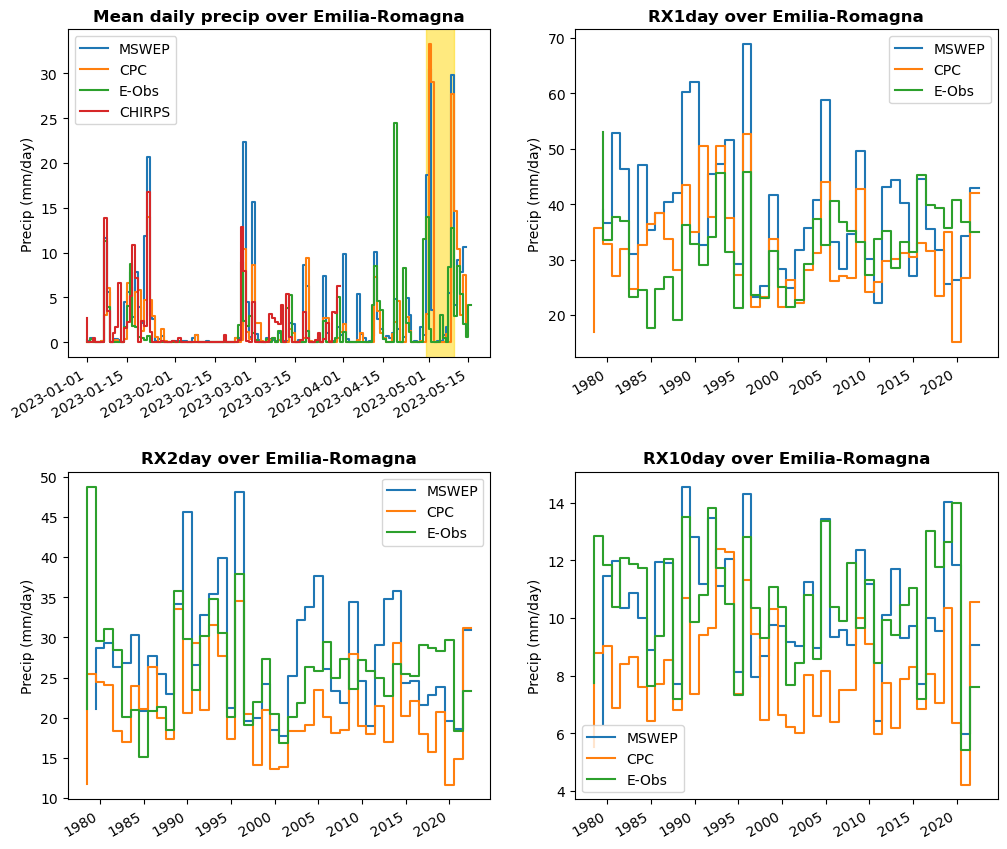

In [94]:
fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (12,10), dpi = 100)
fig.subplots_adjust(hspace = 0.35)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ax = axs[0,0]

mswep_ts.sel(time = "2023").plot(ax = ax, label = "MSWEP", drawstyle = "steps")
cpc_ts.sel(time = "2023").plot(ax = ax, label = "CPC", drawstyle = "steps")
eobs_ts.sel(time = "2023").plot(ax = ax, label = "E-Obs", drawstyle = "steps")
chirps_ts.sel(time = "2023").plot(ax = ax, label = "CHIRPS", drawstyle = "steps")

ax.set_title("Mean daily precip over Emilia-Romagna", fontweight = "bold")
ax.add_patch(Rectangle((np.datetime64("2023-04-30"), -10), width = 10, height = 100, color = "gold", alpha = 0.5))
ax.legend()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ax = axs[0,1]
mswep_ts.resample(time = "AS-JUL").max().plot(ax = ax, label = "MSWEP", drawstyle = "steps")
cpc_ts.resample(time = "AS-JUL").max().plot(ax = ax, label = "CPC", drawstyle = "steps")
eobs_ts.resample(time = "AS-JUL").max().sel(time = slice("1979", None)).plot(ax = ax, label = "E-Obs", drawstyle = "steps")
# chirps_ts.resample(time = "AS-JUL").max().plot(ax = ax, label = "CHIRPS", drawstyle = "steps")

ax.legend()
ax.set_title("RX1day over Emilia-Romagna", fontweight = "bold")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ax = axs[1,0]
mswep_ts.rolling(time = 2).mean().resample(time = "AS-JUL").max().plot(ax = ax, label = "MSWEP", drawstyle = "steps")
cpc_ts.rolling(time = 2).mean().resample(time = "AS-JUL").max().plot(ax = ax, label = "CPC", drawstyle = "steps")
eobs_ts.rolling(time = 2).mean().sel(time = slice("1979", None)).resample(time = "AS-JUL").max().plot(ax = ax, label = "E-Obs", drawstyle = "steps")
# chirps_ts.rolling(time = 2).mean().resample(time = "AS-JUL").max().plot(ax = ax, label = "CHIRPS", drawstyle = "steps")

ax.legend()
ax.set_title("RX2day over Emilia-Romagna", fontweight = "bold")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ax = axs[1,1]
mswep_ts.rolling(time = 10).mean().resample(time = "AS-JUL").max().plot(ax = ax, label = "MSWEP", drawstyle = "steps")
cpc_ts.rolling(time = 10).mean().resample(time = "AS-JUL").max().plot(ax = ax, label = "CPC", drawstyle = "steps")
eobs_ts.rolling(time = 10).mean().sel(time = slice("1979", None)).resample(time = "AS-JUL").max().plot(ax = ax, label = "E-Obs", drawstyle = "steps")
# chirps_ts.rolling(time = 10).mean().resample(time = "AS-JUL").max().plot(ax = ax, label = "CHIRPS", drawstyle = "steps")

ax.legend()
ax.set_title("RX10day over Emilia-Romagna", fontweight = "bold")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

for ax in fig.axes:
    ax.set_xlabel("")
    ax.set_ylabel("Precip (mm/day)")

plt.savefig("fig/emilia-romagna_timeseries.png")

---
## **Station data**

### **Map of station locations**

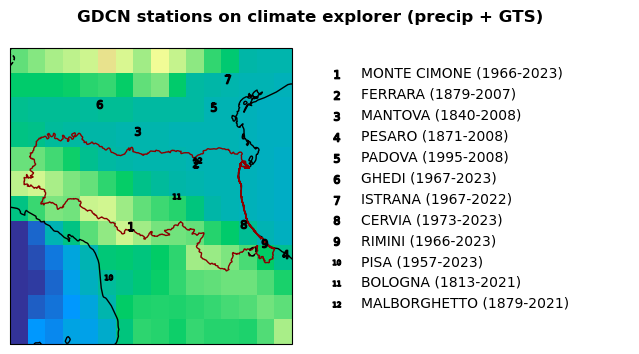

In [125]:
elev = xr.open_dataset("../90_data/tbase_elev-0.25deg.nc").elev.sel(lon = slice(xn,xx), lat = slice(yn,yx))
elev_kwargs = {"cmap" : "terrain", "vmin" : -750, "vmax" : 3000, "add_colorbar" : False}
sf = gpd.read_file("sf/italy-adm1").set_index("NAME_1").loc[["Emilia-Romagna"]]

fig, axs = plt.subplots(ncols = 2, figsize = (8,4), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
ax = axs[0]
elev.plot(ax = ax, **elev_kwargs)
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--")
ax.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)
sf.boundary.plot(ax = ax, color = "darkred", lw = 1)

fl = sorted(glob.glob("data/pgdcngts*.nc")) + sorted(glob.glob("data/peca*.nc")) 
for i in range(len(fl)):
    
    fnm = fl[i]
    da = xr.open_dataset(fnm)
    
    lat = float(da.latitude.strip().split(" ")[0])
    lon = float(da.longitude.strip().split(" ")[0])
    stn = da.description + " ("+"-".join([str(d) for d in da.isel(time = [0,-1]).time.dt.year.values])+")"
    
    ax.scatter(lon, lat, marker = "$"+str(i+1)+"$", color = "k", label = stn, zorder = 99)
    
axs[1].set_axis_off()
fig.legend(bbox_to_anchor = (0.5,0.85), loc = "upper left", edgecolor = "w")
plt.suptitle("GDCN stations on climate explorer (precip + GTS)", fontweight = "bold", y = 0.96)
plt.savefig("fig/gdcn-station-locations.png")

### **Validation of gridded data**

In [2]:
cpc, chirps = [xr.open_dataset("data/"+ds+"_daily_9-13-43-46.nc").precip for ds in ["cpc", "chirps"]]
eobs = xr.open_dataset("data/rr_0.25deg_reg_v25.0ee_9-13E_43-46N.nc").rr
mswep = xr.open_mfdataset("data/mswep_daily_9-13-43-46_*.nc").precip.load()

fl = sorted(glob.glob("data/pgdcngts*.nc")) + sorted(glob.glob("data/peca*.nc")) 

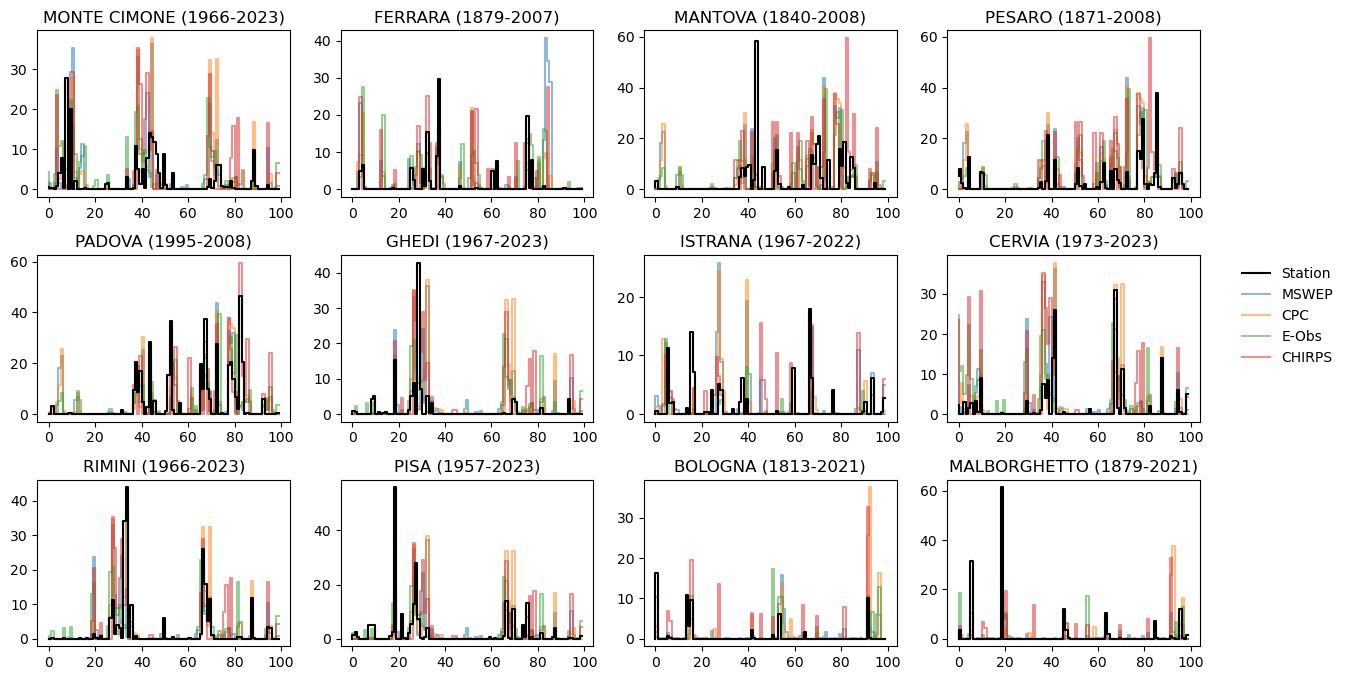

In [14]:
# in the absence of anything more sensible, look at the last 100 observations
fig, axs = plt.subplots(ncols = 4, nrows = 3, figsize = (15,8), dpi = 100)
plt.subplots_adjust(hspace = 0.35)

for i in range(len(fl)):
    
    fnm = fl[i]
    ax = fig.axes[i]
    
    da = xr.open_dataset(fnm).dropna("time", "any")
    
    lat = float(da.latitude.strip().split(" ")[0])
    lon = float(da.longitude.strip().split(" ")[0])
    stn = da.description + " ("+"-".join([str(d) for d in da.isel(time = [0,-1]).time.dt.year.values])+")"
    
    mswep_px = nearest_px(lon, lat, mswep, xcoord = "lat", ycoord = "lon")
    cpc_px = nearest_px(lon, lat, cpc, xcoord = "lat", ycoord = "lon")
    eobs_px = nearest_px(lon, lat, eobs, xcoord = "lat", ycoord = "lon")
    chirps_px = nearest_px(lon, lat, chirps, xcoord = "lat", ycoord = "lon")
    
    if "peca" in fnm:
        da = da.rr
    else:
        da = da.PRCP
    zz = xr.concat([da, mswep_px, cpc_px, eobs_px, chirps_px], "new").dropna("time", "any")
    
    ax.plot(zz.isel(new = 0, time = slice(-100,None)), color = "k", label = "Station", drawstyle = "steps", zorder = 99)
    ax.plot(zz.isel(new = 1, time = slice(-100,None)), label = "MSWEP", drawstyle = "steps", alpha = 0.5)
    ax.plot(zz.isel(new = 2, time = slice(-100,None)), label = "CPC", drawstyle = "steps", alpha = 0.5)
    ax.plot(zz.isel(new = 3, time = slice(-100,None)), label = "E-Obs", drawstyle = "steps", alpha = 0.5)
    ax.plot(zz.isel(new = 4, time = slice(-100,None)), label = "CHIRPS", drawstyle = "steps", alpha = 0.5)
    ax.set_title(stn)
    
fig.legend(["Station", "MSWEP", "CPC", "E-Obs", "CHIRPS"], bbox_to_anchor = (0.92,0.6), loc = "upper left", edgecolor = "w")
plt.savefig("fig/station-validation.png")